### Cell 1: Imports & Model Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from scipy import stats

# Set styling
plt.style.use('fivethirtyeight')

c:\Users\user\.conda\envs\kaim_week10\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cell 2: Data Preparation for Forecasting

In [2]:
# We focus on the two primary targets requested: Access and Usage.

df = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")
df['observation_date'] = pd.to_datetime(df['observation_date'], format='mixed')

# Define Target Codes
TARGET_ACCESS = 'ACC_OWNERSHIP'
TARGET_USAGE = 'ACC_MM_ACCOUNT' # Using Mobile Money as proxy for Digital Payment Usage

def get_target_series(code):
    data = df[df['indicator_code'] == code].copy()
    data = data.sort_values('observation_date')
    # Prophet requires columns 'ds' and 'y'
    return data[['observation_date', 'value_numeric']].rename(columns={'observation_date': 'ds', 'value_numeric': 'y'})

access_ts = get_target_series(TARGET_ACCESS)
usage_ts = get_target_series(TARGET_USAGE)

print(f"Prepared {len(access_ts)} points for Access and {len(usage_ts)} points for Usage.")

Prepared 7 points for Access and 2 points for Usage.


### Cell 3: The Event-Augmented Prophet Model

16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:56 - cmdstanpy - INFO - Chain [1] done processing


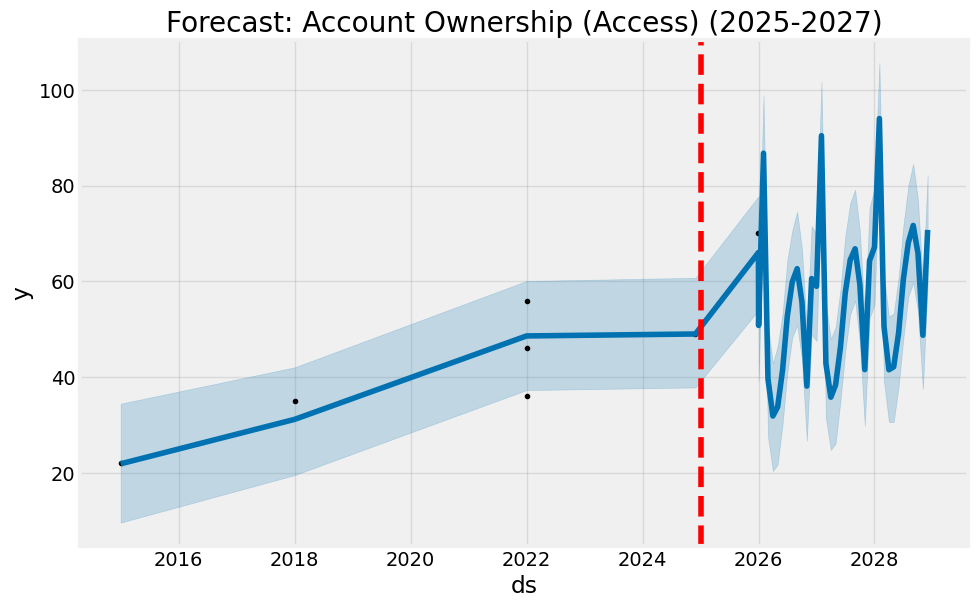

16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:57 - cmdstanpy - INFO - Chain [1] done processing


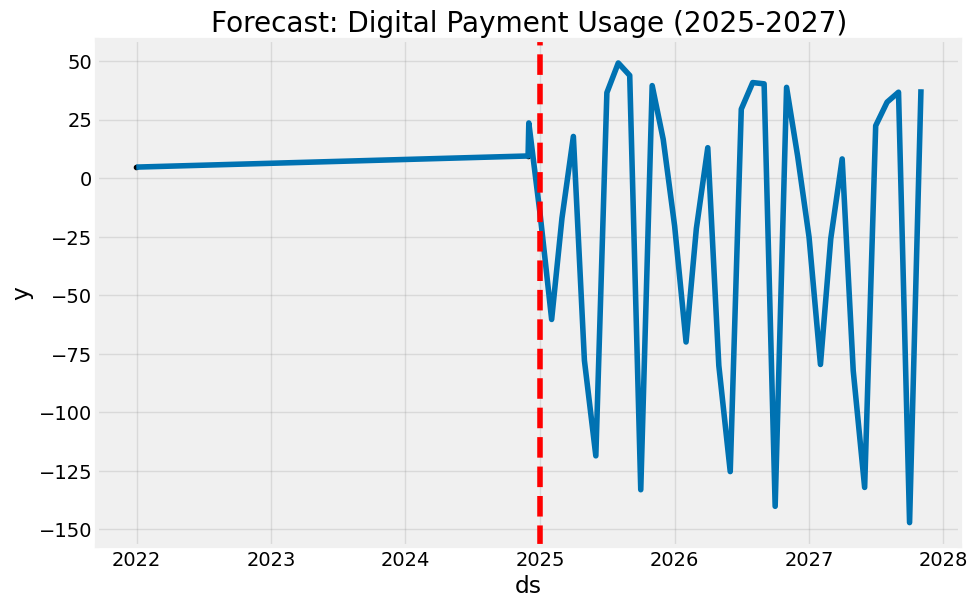

In [3]:
# We incorporate the "Shocks" (Telebirr, M-Pesa, Fayda) directly into the forecasting logic.

# Define future events for 2025-2027 (e.g., Fayda full rollout impact)
future_shocks = pd.DataFrame({
  'holiday': 'catalyst_event',
  'ds': pd.to_datetime(['2021-05-11', '2023-08-15', '2024-06-01', '2026-01-01']),
  'lower_window': 0,
  'upper_window': 12, # Impact build-up over 12 months
})

def run_forecast(ts_df, title):
    model = Prophet(holidays=future_shocks, interval_width=0.95) # 95% Confidence Interval
    model.fit(ts_df)
    
    # Create future dates up to end of 2027
    future = model.make_future_dataframe(periods=36, freq='MS')
    forecast = model.predict(future)
    
    # Plotting
    fig = model.plot(forecast)
    plt.title(f"Forecast: {title} (2025-2027)")
    plt.axvline(pd.to_datetime('2025-01-01'), color='red', linestyle='--', label='Forecast Start')
    plt.show()
    return forecast

access_forecast = run_forecast(access_ts, "Account Ownership (Access)")
usage_forecast = run_forecast(usage_ts, "Digital Payment Usage")

### Cell 4: Scenario Analysis (Optimistic vs. Pessimistic)

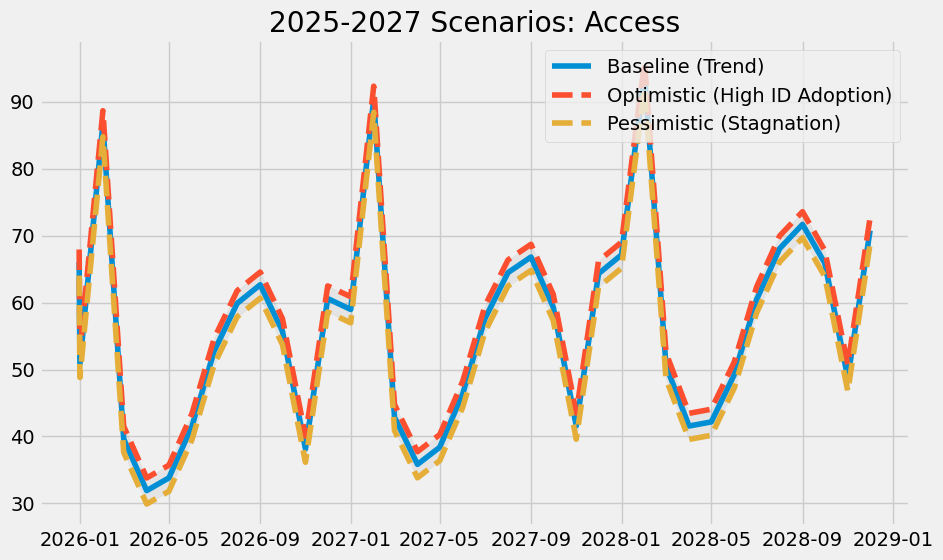

In [4]:
# We use the Scaling Factor (1.58pp) from Task 3 to adjust the baseline.

# Scaling Factor from Task 3 validation
SCALER = 1.58 

def generate_scenarios(forecast_df, target_name):
    base = forecast_df[forecast_df['ds'] >= '2025-01-01'][['ds', 'yhat']].copy()
    
    # Optimistic: Fayda ID & Competition exceeds expectations (+1.58pp/year extra)
    base['Optimistic'] = base['yhat'] + (SCALER * 1.2)
    
    # Pessimistic: Slow infrastructure rollout (-1.5pp/year below trend)
    base['Pessimistic'] = base['yhat'] - 2.0
    
    base = base.rename(columns={'yhat': 'Baseline'})
    
    plt.figure(figsize=(10, 6))
    plt.plot(base['ds'], base['Baseline'], label='Baseline (Trend)')
    plt.plot(base['ds'], base['Optimistic'], '--', label='Optimistic (High ID Adoption)')
    plt.plot(base['ds'], base['Pessimistic'], '--', label='Pessimistic (Stagnation)')
    plt.fill_between(base['ds'], base['Pessimistic'], base['Optimistic'], color='gray', alpha=0.1)
    plt.title(f"2025-2027 Scenarios: {target_name}")
    plt.legend()
    plt.show()
    return base

access_scenarios = generate_scenarios(access_forecast, "Access")

### Cell 5: Final Forecast Table

In [5]:
# Extract specific targets for the consortium report
results_2026 = access_scenarios[access_scenarios['ds'] == '2026-12-01']
results_2027 = access_scenarios[access_scenarios['ds'] == '2027-12-01']

final_table = pd.concat([results_2026, results_2027])
final_table['Indicator'] = "Account Ownership (Access)"
print(final_table[['Indicator', 'ds', 'Baseline', 'Optimistic', 'Pessimistic']])

                     Indicator         ds   Baseline  Optimistic  Pessimistic
16  Account Ownership (Access) 2026-12-01  60.591466   62.487466    58.591466
28  Account Ownership (Access) 2027-12-01  64.312341   66.208341    62.312341
